<a href="https://colab.research.google.com/github/dbuckman17/TIPC-Portfolio-Construction-Code/blob/main/Impact_First_Optimizerv8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Function to explain selection process to the user
def explain_selection_process():
    print("You can select categories you wish to include in the impact optimization.")
    print("To select a category, enter the category number. For example, to select 'On-Ground Additionality', enter '1'.")
    print("In the next step, you will have the opportunity to exclude and customize weights for metrics within categories\n")
    print("Here are the available categories and their associated metrics:\n")

def display_categories():
    for i, (category, metrics) in enumerate(categories.items()):
        print(f"{i+1}. {category}")
        for metric in metrics:
            print(f"   - {metric}")


In [2]:
# Function to select categories
def select_categories():
    explain_selection_process()
    display_categories()
    selected_categories = []
    while True:
        try:
            selection = input("\nEnter the numbers of the categories you wish to include, separated by commas (e.g., 1,3): ")
            selected_indices = [int(index.strip()) - 1 for index in selection.split(',')]
            selected_categories = [list(categories.keys())[i] for i in selected_indices if 0 <= i < len(categories)]
            if selected_categories:
                selected_metrics = [metric for category in selected_categories for metric in categories[category]]
                return selected_categories, selected_metrics
            else:
                print("Please select at least one valid category.")
        except ValueError:
            print("Invalid input. Please enter numbers separated by commas.")



In [3]:
# Initialize a DataFrame to store user inputs
def initialize_weights_df(selected_metrics):
    equal_weight = 1 / len(selected_metrics)
    return pd.DataFrame({"Weight": [equal_weight] * len(selected_metrics)}, index=selected_metrics)

# Function to allow user to adjust weights
def adjust_weights(weights_df):
    print("The selected criteria will be weighted equally by default.\n")
    while True:
        adjust = input("Do you wish to adjust the weightings - weights should add to 1? (yes/no): ").strip().lower()
        if adjust in ['yes', 'no']:
            break
        else:
            print("Invalid input. Please enter 'yes' or 'no'.\n")

    if adjust == 'yes':
        for metric in weights_df.index:
            while True:
                weight = input(f"Enter the new weight for {metric} (value between 0 and 1): ").strip()
                try:
                    weight = float(weight)
                    if 0 <= weight <= 1:
                        weights_df.at[metric, "Weight"] = weight
                        break
                    else:
                        print("Invalid input. Weight must be between 0 and 1.\n")
                except ValueError:
                    print("Invalid input. Please enter a number.\n")

        # Check if the total weight sums to 1
        total_weight = weights_df["Weight"].sum()
        if total_weight != 1:
            print(f"Total weight is {total_weight}. Adjusting weights to sum to 1.\n")
            weights_df["Weight"] = weights_df["Weight"] / total_weight

        print("\nHere are the weights you've entered:")
        print(weights_df)

        while True:
            confirm = input("Are these weights correct? (yes/no): ").strip().lower()
            if confirm in ['yes', 'no']:
                break
            else:
                print("Invalid input. Please enter 'yes' or 'no'.\n")
        if confirm == 'yes':
            print("Weights have been adjusted successfully.\n")
        else:
            print("Let's adjust the weights again.\n")
            weights_df = adjust_weights(weights_df)
    return weights_df


In [4]:
# Define the helper functions in one cell
def get_unique_values(series):
    unique_values = set()
    for item in series.dropna():
        unique_values.update([i.strip() for i in item.split(';')])  # Strip leading/trailing spaces
    return list(unique_values)

def get_float_input(prompt, min_value=None, max_value=None):
    while True:
        try:
            value = float(input(prompt))
            if (min_value is not None and value < min_value) or (max_value is not None and value > max_value):
                print(f"Invalid input. Please enter a number between {min_value} and {max_value}.")
            else:
                return value
        except ValueError:
            print("Invalid input. Please enter a number.")

def get_yes_no_input(prompt):
    while True:
        value = input(prompt).strip().lower()
        if value in ['yes', 'no']:
            return value
        else:
            print("Invalid input. Please enter 'yes' or 'no'.")


In [5]:
# Define the function to handle category constraints
def handle_category_constraints(category, fund_info, constraints):
    exclude = get_yes_no_input(f"\nDo you wish to exclude any {category}? (yes/no): ")
    if exclude == 'yes':
        if category in ['Geography', 'Impact Theme']:
            unique_values = get_unique_values(fund_info[category])
        else:
            unique_values = fund_info[category].unique()

        unique_values_dict = {i+1: value for i, value in enumerate(unique_values)}
        print(f"Available {category}:")
        for num, val in unique_values_dict.items():
            print(f"{num}. {val}")

        while True:
            exclusions = input(f"Enter the numbers of any {category} to exclude, separated by commas if multiple: ").split(',')
            try:
                exclusion_numbers = [int(item.strip()) for item in exclusions]
                if all(num in unique_values_dict for num in exclusion_numbers):
                    constraints[f'exclude_{category}'] = [unique_values_dict[num] for num in exclusion_numbers]
                    break
                else:
                    print("Invalid exclusions. Please enter valid numbers from the available options.\n")
            except ValueError:
                print("Invalid input. Please enter numbers separated by commas.\n")
    else:
        constraints[f'exclude_{category}'] = []

    bounds = get_yes_no_input(f"\nDo you wish to set specific bounds for any remaining {category}? (yes/no): ")
    if bounds == 'yes':
        if category in ['Geography', 'Impact Theme']:
            remaining_options = [item for item in get_unique_values(fund_info[category]) if item not in constraints[f'exclude_{category}']]
        else:
            remaining_options = [item for item in fund_info[category].unique() if item not in constraints[f'exclude_{category}']]

        remaining_options_dict = {i+1: value for i, value in enumerate(remaining_options)}
        print(f"\nRemaining {category}:")
        for num, val in remaining_options_dict.items():
            print(f"{num}. {val}")

        while True:
            options_to_bound = input(f"Enter the numbers of the {category} to set bounds for, separated by commas if multiple: ").split(',')
            try:
                bound_numbers = [int(item.strip()) for item in options_to_bound]
                if all(num in remaining_options_dict for num in bound_numbers):
                    break
                else:
                    print("Invalid selection. Please enter valid numbers from the remaining options.\n")
            except ValueError:
                print("Invalid input. Please enter numbers separated by commas.\n")

        category_bounds = {}
        for num in bound_numbers:
            option = remaining_options_dict[num]
            while True:
                try:
                    lower_bound = float(input(f"Enter the lower bound for {option} (as a decimal between 0 and 1): "))
                    upper_bound = float(input(f"Enter the upper bound for {option} (as a decimal between 0 and 1): "))
                    if 0 <= lower_bound <= 1 and 0 <= upper_bound <= 1 and lower_bound <= upper_bound:
                        category_bounds[option] = (lower_bound, upper_bound)
                        break
                    else:
                        print("Invalid bounds. Ensure both values are between 0 and 1, and the lower bound is not higher than the upper bound.\n")
                except ValueError:
                    print("Invalid input. Please enter numbers between 0 and 1.\n")
        constraints[f'{category}_bounds'] = category_bounds
    else:
        constraints[f'{category}_bounds'] = {}


In [6]:
# Define the collect_constraints function
def collect_constraints(fund_info):
    constraints = {}

    # Total investment amount
    constraints['total_investment'] = get_float_input("Enter the total investment amount: ", min_value=0)

    # Diversification requirement
    constraints['max_allocation'] = get_float_input("Enter the maximum percent allocation to a single fund (as a decimal): ", min_value=0, max_value=1)

    # Constraints for in_portfolio and greenlight
    constraints['in_portfolio'] = get_yes_no_input("Do you wish to only include current portfolio funds? (yes/no): ")
    if constraints['in_portfolio'] == 'yes':
        constraints['greenlight'] = get_yes_no_input("Do you wish to include funds currently in the greenlight process? (yes/no): ")
    else:
        constraints['greenlight'] = 'yes'

    # Minimum targeted base case IRR
    constraints['min_base_case_irr'] = get_float_input("Enter the minimum targeted base case IRR (as a decimal): ", min_value=0)

    # Maximum drawdowns
    constraints['max_drawdown_1_in_10'] = get_float_input("Enter your maximum loss from a 1 in 10 drawdown scenario. Enter a positive # (as a decimal): ", min_value=0, max_value=1)
    constraints['max_drawdown_1_in_100'] = get_float_input("Enter your maximum loss from a 1 in 100 drawdown scenario. Enter a positive # (as a decimal): ", min_value=0, max_value=1)

    # Handle geographies
    handle_category_constraints('Geography', fund_info, constraints)

    # Handle asset classes
    handle_category_constraints('Asset Class', fund_info, constraints)

    # Handle impact themes
    handle_category_constraints('Impact Theme', fund_info, constraints)

    # Handle archetypes
    handle_category_constraints('Archetype', fund_info, constraints)

    return constraints


In [7]:
# Define the review_constraints function
def review_constraints(constraints, fund_info):
    print("\nCurrent Constraints:")
    for i, (key, value) in enumerate(constraints.items(), start=1):
        print(f"{i}. {key}: {value}")

    if get_yes_no_input("\nDo you want to adjust any constraints? (yes/no): ") == 'yes':
        while True:
            try:
                constraint_numbers = input("Enter the numbers of the constraints you want to adjust, separated by commas: ").split(',')
                selected_constraints = [int(num.strip()) for num in constraint_numbers]
                if all(1 <= num <= len(constraints) for num in selected_constraints):
                    break
                else:
                    print("Invalid selection. Please enter valid numbers from the list.")
            except ValueError:
                print("Invalid input. Please enter numbers separated by commas.")

        # Create a copy of the current constraints keys to avoid modifying the dictionary during iteration
        constraint_keys = list(constraints.keys())

        for num in selected_constraints:
            key = constraint_keys[num - 1]  # Access key based on the initial list of keys
            if key == 'total_investment':
                constraints[key] = get_float_input("Enter the total investment amount: ", min_value=0)
            elif key == 'max_allocation':
                constraints[key] = get_float_input("Enter the maximum percent allocation to a single fund (as a decimal): ", min_value=0, max_value=1)
            elif key == 'in_portfolio':
                constraints[key] = get_yes_no_input("Do you wish to only include current portfolio funds? (yes/no): ")
                if constraints[key] == 'yes':
                    constraints['greenlight'] = get_yes_no_input("Do you wish to include funds currently in the greenlight process? (yes/no): ")
                else:
                    constraints['greenlight'] = 'yes'
            elif key == 'greenlight':
                if constraints['in_portfolio'] == 'yes':
                    constraints[key] = get_yes_no_input("Do you wish to include funds currently in the greenlight process? (yes/no): ")
                else:
                    print("Greenlight constraint is only relevant if 'in_portfolio' is 'yes'.")
            elif key == 'min_base_case_irr':
                constraints[key] = get_float_input("Enter the minimum targeted base case IRR (as a decimal): ", min_value=0)
            elif key == 'max_drawdown_1_in_10':
                constraints[key] = get_float_input("Enter your maximum loss from a 1 in 10 drawdown scenario. Enter a positive # (as a decimal): ", min_value=0, max_value=1)
            elif key == 'max_drawdown_1_in_100':
                constraints[key] = get_float_input("Enter your maximum loss from a 1 in 100 drawdown scenario. Enter a positive # (as a decimal): ", min_value=0, max_value=1)
            elif key.startswith('exclude_') or key.endswith('_bounds'):
                category = key.split('_')[1] if key.startswith('exclude_') else key.split('_')[0]
                handle_category_constraints(category, fund_info, constraints)
        return review_constraints(constraints, fund_info)
    return constraints


In [8]:
# Function to calculate weighted scores and optimize the portfolio
def optimize_portfolio(fund_data, weights_df, constraints):
    # Calculate the weighted impact score for each fund
    impact_scores = fund_data[weights_df.index].values
    weights = weights_df["Weight"].values
    fund_data['WeightedImpactScore'] = np.dot(impact_scores, weights)

    # Apply constraints
    total_investment = constraints.get('total_investment', 100000000)  # Default $100M if not provided
    max_allocation = constraints.get('max_allocation', 1)  # Default 100% if not provided
    min_base_case_irr = constraints.get('min_base_case_irr', 0.000000000000000001)  # Default 0% if not provided
    max_drawdown_1_in_10 = constraints.get('max_drawdown_1_in_10', 1)  # Default 100% if not provided
    max_drawdown_1_in_100 = constraints.get('max_drawdown_1_in_100', 1)  # Default to 100% if not provided

    # Filter fund_data based on 'in_portfolio' and 'greenlight' constraints
    if constraints['in_portfolio'] == 'yes':
        if constraints['greenlight'] == 'yes':
            fund_data = fund_data[(fund_data['In Portfolio'] == 'Y') | (fund_data['Greenlight'] == 'Y')]
        else:
            fund_data = fund_data[fund_data['In Portfolio'] == 'Y']

    # Exclude funds based on constraints
    for category in ['Geography', 'Asset Class', 'Impact Theme', 'Archetype']:
        if f'exclude_{category}' in constraints:
            fund_data = fund_data[~fund_data[category].apply(lambda x: any(exclusion in x for exclusion in constraints[f'exclude_{category}']))]


    # Reset DataFrame index
    fund_data = fund_data.reset_index(drop=True)

    # Define the optimization problem
    c = -fund_data['WeightedImpactScore'].values  # Negative because we want to maximize

    # Equality constraint: sum of allocations equals total investment
    A_eq = [np.ones(fund_data.shape[0])]  # Vector of ones to sum all allocations
    b_eq = [total_investment]  # Total investment amount

    # Inequality constraints
    A_ub = []
    b_ub = []

    # Upper bound constraint for IRR
    irr_constraint = fund_data['Target net IRR (%)'].values
    A_ub.append(-irr_constraint)  # Multiply by -1 to transform the inequality
    b_ub.append(-min_base_case_irr * total_investment)  # Multiply by -1 to transform the inequality

    # Drawdown constraints
    drawdown_1_in_10 = fund_data['1 in 10 Loss'].values
    drawdown_1_in_100 = fund_data['1 in 100 Loss'].values

    A_ub.append(drawdown_1_in_10)
    b_ub.append(max_drawdown_1_in_10 * total_investment)

    A_ub.append(drawdown_1_in_100)
    b_ub.append(max_drawdown_1_in_100 * total_investment)

    # Bounds for each fund allocation
    bounds = [(0, min(row['Fund Size ($$)'], total_investment * max_allocation)) for _, row in fund_data.iterrows()]

    # Function to create category constraints
    def add_category_constraints(category):
        if f'{category}_bounds' in constraints:
            for cat_option, (lower_bound, upper_bound) in constraints[f'{category}_bounds'].items():
                cat_constraint = np.zeros(fund_data.shape[0])
                for idx, row in fund_data.iterrows():
                    categories = str(row[category]).split(';')
                    if cat_option in categories:
                        cat_constraint[idx] = 1 / len(categories)

                # Upper bound constraint
                A_ub.append(cat_constraint)
                b_ub.append(upper_bound * total_investment)

                # Lower bound constraint
                A_ub.append(-cat_constraint)
                b_ub.append(-lower_bound * total_investment)

    # Add category constraints to the optimization problem
    add_category_constraints('Geography')
    add_category_constraints('Asset Class')
    add_category_constraints('Impact Theme')
    add_category_constraints('Archetype')

    # Perform linear programming optimization
    result = linprog(c, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')

    if result.success:
        fund_data['Allocation'] = result.x
        allocated_funds = fund_data[fund_data['Allocation'] > 0]
        total_score = -result.fun
        return allocated_funds, total_score, fund_data
    else:
        print("Optimization failed.")
        if result.status == 2:
            print("The problem appears to be infeasible. Consider relaxing the following constraints:")
            print("1. Total investment amount")
            print("2. Maximum allocation to a single fund")
            print("3. Minimum targeted base case IRR")
            print("4. Category-specific allocation bounds")
            print("5. Maximum drawdown constraints")
        elif result.status == 3:
            print("The problem appears to be unbounded. This might indicate an error in the constraints.")
        else:
            print(f"Optimization failed with status code: {result.status}")
        return None, None, fund_data


In [9]:
# Function to calculate risk metrics for Private Debt
#Eventually add this to different sheet
def calculate_private_debt_risk_metrics():
    total_loss_stress = [-0.004, -0.0175, -0.05, -0.0975, -0.16]
    prob_stress = [0.025, 0.075, 0.20, 0.50, 0.75]
    adjusted_prob_stress = [p / 2 for p in prob_stress]
    std_devs = []
    percentile_10s = []
    percentile_1s = []
    for loss, prob in zip(total_loss_stress, adjusted_prob_stress):
        z_score = norm.ppf(prob)
        std_dev = loss / z_score
        std_devs.append(std_dev)
        z_score_10th = norm.ppf(0.1 / 2) #adjustment for assumed 1-sided distribution of assets (following CB Monte Carlo methodology)
        z_score_1st = norm.ppf(0.01 / 2) #adjustment for assumed 1-sided distribution of assets (following CB Monte Carlo methodology)
        percentile_10 = z_score_10th * std_dev
        percentile_1 = z_score_1st * std_dev
        percentile_10 = max(percentile_10, -1)
        percentile_1 = max(percentile_1, -1)
        percentile_10s.append(percentile_10)
        percentile_1s.append(percentile_1)
    return std_devs, percentile_10s, percentile_1s

# Function to calculate risk metrics for Equity/Real Assets
def calculate_equity_real_assets_risk_metrics():
    total_loss_stress = [-0.01, -0.035, -0.075, -0.2145, -0.40]
    prob_stress = [0.05, 0.15, 0.30, 0.65, 0.90]
    adjusted_prob_stress = [p / 2 for p in prob_stress]
    std_devs = []
    percentile_10s = []
    percentile_1s = []
    for loss, prob in zip(total_loss_stress, adjusted_prob_stress):
        z_score = norm.ppf(prob)
        std_dev = loss / z_score
        std_devs.append(std_dev)
        z_score_10th = norm.ppf(0.1 / 2) #adjustment for assumed 1-sided distribution of assets (following CB Monte Carlo methodology)
        z_score_1st = norm.ppf(0.01 / 2) #adjustment for assumed 1-sided distribution of assets (following CB Monte Carlo methodology)
        percentile_10 = z_score_10th * std_dev
        percentile_1 = z_score_1st * std_dev
        percentile_10 = max(percentile_10, -1)
        percentile_1 = max(percentile_1, -1)
        percentile_10s.append(percentile_10)
        percentile_1s.append(percentile_1)
    return std_devs, percentile_10s, percentile_1s

# Function to append risk metrics to the fund data
def append_risk_metrics(fund_data):
    # Calculate risk metrics for Private Debt
    private_debt_std_devs, private_debt_10s, private_debt_1s = calculate_private_debt_risk_metrics()
    equity_real_assets_std_devs, equity_real_assets_10s, equity_real_assets_1s = calculate_equity_real_assets_risk_metrics()

    # Initialize new columns
    fund_data['Standard Deviation'] = np.nan
    fund_data['1 in 10 Loss'] = np.nan
    fund_data['1 in 100 Loss'] = np.nan

    # Apply metrics to each fund based on Asset Class and Risk of Loss
    for idx, row in fund_data.iterrows():
        risk_level = int(row['Risk of loss']) - 1  # Adjust risk level to zero-based index

        if row['Asset Class'] == 'Private Debt':
            fund_data.at[idx, 'Standard Deviation'] = private_debt_std_devs[risk_level]
            fund_data.at[idx, '1 in 10 Loss'] = -private_debt_10s[risk_level]
            fund_data.at[idx, '1 in 100 Loss'] = -private_debt_1s[risk_level]
        else:
            fund_data.at[idx, 'Standard Deviation'] = equity_real_assets_std_devs[risk_level]
            fund_data.at[idx, '1 in 10 Loss'] = -equity_real_assets_10s[risk_level]
            fund_data.at[idx, '1 in 100 Loss'] = -equity_real_assets_1s[risk_level]

    return fund_data

In [10]:
from tabulate import tabulate

def get_yes_no_input(prompt):
    while True:
        value = input(prompt).strip().lower()
        if value in ['yes', 'no']:
            return value
        else:
            print("Invalid input. Please enter 'yes' or 'no'.")

def portfolio_analytics(allocated_funds, constraints):
    # Extract constraints
    total_investment = constraints['total_investment']
    max_allocation = constraints['max_allocation']
    min_base_case_irr = constraints['min_base_case_irr']
    max_drawdown_1_in_10 = constraints['max_drawdown_1_in_10']
    max_drawdown_1_in_100 = constraints['max_drawdown_1_in_100']

    # Select relevant columns for the output table
    columns = ['Fund Name', 'Allocation', 'Asset Class', 'In Portfolio', 'Greenlight', 'Risk of loss', 'Target net IRR (%)',
               'Geography', 'Impact Theme', 'Archetype', 'WeightedImpactScore', '1 in 10 Loss', '1 in 100 Loss']

    # Sort the DataFrame by the 'Fund Name' column
    output_table = allocated_funds.sort_values(by='Fund Name')

    # Format the table for better readability
    output_table['Allocation'] = output_table['Allocation'].apply(lambda x: f"${x:,.2f}")
    output_table['Target net IRR (%)'] = output_table['Target net IRR (%)'].apply(lambda x: f"{x:.2%}")
    output_table['1 in 10 Loss'] = output_table['1 in 10 Loss'].apply(lambda x: f"{x:.2%}")
    output_table['1 in 100 Loss'] = output_table['1 in 100 Loss'].apply(lambda x: f"{x:.2%}")
    output_table['WeightedImpactScore'] = output_table['WeightedImpactScore'].apply(lambda x: f"{x:.2f}")

    # Calculate weighted average impact score for the entire portfolio
    total_allocation = allocated_funds['Allocation'].sum()
    weighted_avg_impact_score = (allocated_funds['WeightedImpactScore'].astype(float) * allocated_funds['Allocation']).sum() / total_allocation

    # Calculate other allocation-weighted analytics
    weighted_avg_risk_of_loss = (allocated_funds['Risk of loss'].astype(float) * allocated_funds['Allocation']).sum() / total_allocation
    weighted_avg_irr = (allocated_funds['Target net IRR (%)'].astype(float) * allocated_funds['Allocation']).sum() / total_allocation
    weighted_avg_1_in_10_loss = (allocated_funds['1 in 10 Loss'].astype(float) * allocated_funds['Allocation']).sum() / total_allocation
    weighted_avg_1_in_100_loss = (allocated_funds['1 in 100 Loss'].astype(float) * allocated_funds['Allocation']).sum() / total_allocation

    #collect the output as HTML
    html_output = []

    # Print the table
    print("\nPortfolio Analytics:")
    print(output_table.to_string(index=False))
    output_table_html = output_table.to_html(index=False, border=0, classes='table table-striped')
    html_output.append(output_table_html)

    # Display the portfolio metrics in a table
    portfolio_metrics = [
        ["Weighted Average Impact Score", f"{weighted_avg_impact_score:.2f}"],
        ["Weighted Average Risk of Loss", f"{weighted_avg_risk_of_loss:.2f}"],
        ["Weighted Average IRR", f"{weighted_avg_irr:.2%}"],
        ["Weighted Average 1 in 10 Loss", f"{weighted_avg_1_in_10_loss:.2%}"],
        ["Weighted Average 1 in 100 Loss", f"{weighted_avg_1_in_100_loss:.2%}"]
    ]

    print("\nEntire Portfolio Metrics:")
    print(tabulate(portfolio_metrics, headers=["Metric", "Value"], tablefmt="grid"))
    html_output.append(tabulate(portfolio_metrics, headers=["Metric", "Value"], tablefmt="html"))

    # Ask the user if they wish to verify constraints
    verify_constraints = get_yes_no_input("Do you wish to verify that all constraints were met? (yes/no): ")
    if verify_constraints == 'yes':
        # Create the constraint checklist
        constraint_checklist = []

        # Check total investment constraint
        total_allocated = allocated_funds['Allocation'].sum()
        total_investment_check = total_allocated <= total_investment +.01
        constraint_checklist.append(["Total Investment", f"${total_allocated:,.2f} <= ${total_investment:,.2f}", "✓" if total_investment_check else "✗"])

        # Check max allocation constraint
        max_allocation_check = (allocated_funds['Allocation'] <= max_allocation * total_investment + 1).all()
        constraint_checklist.append(["Max Allocation per Fund", f"Each Fund <= {max_allocation * 100:.2f}% of Total Investment", "✓" if max_allocation_check else "✗"])

        # Check minimum targeted base case IRR
        min_base_case_irr_check = weighted_avg_irr >= min_base_case_irr
        constraint_checklist.append(["Min Base Case IRR", f"{weighted_avg_irr:.2%} >= {min_base_case_irr:.2%}", "✓" if min_base_case_irr_check else "✗"])

        # Check drawdown constraints
        drawdown_1_in_10_check = (allocated_funds['1 in 10 Loss'].astype(float) * allocated_funds['Allocation']).sum() <= max_drawdown_1_in_10 * total_investment +.01
        constraint_checklist.append(["Max 1 in 10 Year Drawdown", f"${(allocated_funds['1 in 10 Loss'].astype(float) * allocated_funds['Allocation']).sum():,.2f} <= ${max_drawdown_1_in_10 * total_investment:,.2f}", "✓" if drawdown_1_in_10_check else "✗"])

        drawdown_1_in_100_check = (allocated_funds['1 in 100 Loss'].astype(float) * allocated_funds['Allocation']).sum() <= max_drawdown_1_in_100 * total_investment +.01
        constraint_checklist.append(["Max 1 in 100 Year Drawdown", f"${(allocated_funds['1 in 100 Loss'].astype(float) * allocated_funds['Allocation']).sum():,.2f} <= ${max_drawdown_1_in_100 * total_investment:,.2f}", "✓" if drawdown_1_in_100_check else "✗"])

        # Check each allocation to a fund is <= the fund size
        fund_size_check = (allocated_funds['Allocation'] <= allocated_funds['Fund Size ($$)']+.01).all()
        constraint_checklist.append(["Allocation <= Fund Size", "Each Allocation <= Fund Size", "✓" if fund_size_check else "✗"])

        # Add category bounds checks
        for category in ['Geography', 'Asset Class', 'Impact Theme', 'Archetype']:
            if f'{category}_bounds' in constraints:
                for cat_option, (lower_bound, upper_bound) in constraints[f'{category}_bounds'].items():
                    total_cat_allocation = 0
                    for idx, row in allocated_funds.iterrows():
                        categories = str(row[category]).split(';')
                        if cat_option in categories:
                            allocation = row['Allocation']
                            total_cat_allocation += allocation / len(categories)
                    lower_bound_check = total_cat_allocation >= lower_bound * total_investment
                    upper_bound_check = total_cat_allocation <= upper_bound * total_investment
                    constraint_checklist.append([f"{category} - {cat_option} Lower Bound", f"${total_cat_allocation:,.2f} >= ${lower_bound * total_investment:,.2f}", "✓" if lower_bound_check else "✗"])
                    constraint_checklist.append([f"{category} - {cat_option} Upper Bound", f"${total_cat_allocation:,.2f} <= ${upper_bound * total_investment:,.2f}", "✓" if upper_bound_check else "✗"])

        # Add exclusion checks
        for category in ['Geography', 'Asset Class', 'Impact Theme', 'Archetype']:
            if f'exclude_{category}' in constraints:
                excluded_funds = allocated_funds[allocated_funds[category].apply(lambda x: any(exclusion in x.split(';') for exclusion in constraints[f'exclude_{category}']))]
                exclusion_check = excluded_funds.empty
                constraint_checklist.append([f"{category} Exclusions", f"No funds in {constraints[f'exclude_{category}']}", "✓" if exclusion_check else "✗"])

        # Add In Portfolio and Greenlight checks
        if constraints.get('in_portfolio') == 'yes':
            if constraints.get('greenlight') == 'yes':
                in_portfolio_greenlight_check = ((allocated_funds['In Portfolio'] == 'Y') | (allocated_funds['Greenlight'] == 'Y')).all()
                constraint_checklist.append(["In Portfolio or Greenlight", "All funds should be either in portfolio or in greenlight process", "✓" if in_portfolio_greenlight_check else "✗"])
            else:
                in_portfolio_check = (allocated_funds['In Portfolio'] == 'Y').all()
                constraint_checklist.append(["In Portfolio", "All funds should be in portfolio", "✓" if in_portfolio_check else "✗"])

        # Print the constraint checklist
        print("\nConstraint Checklist:")
        print(tabulate(constraint_checklist, headers=["Constraint", "Check", "Status"], tablefmt="grid"))

        # Convert the constraint checklist to HTML
        html_output.append(tabulate(constraint_checklist, headers=["Constraint", "Check", "Status"], tablefmt="html"))

        # Check if all constraints are met
        if not all(constraint[2] == "✓" for constraint in constraint_checklist):
            print("\nSome constraints are not met. Please review the constraints and adjust accordingly.")
            html_output.append("<p>Some constraints are not met. Please review the constraints and adjust accordingly.</p>")

    return "\n".join(html_output)


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np
import io
import base64

def portfolio_analytics_visuals(allocated_funds, fund_data, constraints):
    visuals_html = ''

    def save_plot_to_html(title):
        img = io.BytesIO()
        plt.savefig(img, format='png', bbox_inches='tight')
        img.seek(0)
        plot_url = base64.b64encode(img.getvalue()).decode()
        visuals_html = f'<img src="data:image/png;base64,{plot_url}" alt="{title}">'
        plt.show()  # This will display the plot
        return visuals_html

    # Pie chart for Asset Class Breakdown weighted by allocation
    plt.figure(figsize=(10, 6))
    asset_class_allocations = allocated_funds.groupby('Asset Class')['Allocation'].sum()
    plt.pie(asset_class_allocations, labels=asset_class_allocations.index, autopct='%1.1f%%', colors=sns.color_palette('tab10'))
    plt.title('Asset Class Breakdown')
    visuals_html += save_plot_to_html('Asset Class Breakdown')

    # Pie chart for Impact Theme Breakdown weighted by allocation
    impact_theme_allocations = defaultdict(float)
    for idx, row in allocated_funds.iterrows():
        themes = row['Impact Theme'].split(';')
        allocation_per_theme = row['Allocation'] / len(themes)
        for theme in themes:
            impact_theme_allocations[theme.strip()] += allocation_per_theme

    plt.figure(figsize=(10, 6))
    impact_theme_labels, impact_theme_sizes = zip(*impact_theme_allocations.items())
    plt.pie(impact_theme_sizes, labels=impact_theme_labels, autopct='%1.1f%%', colors=sns.color_palette('tab10'))
    plt.title('Impact Theme Breakdown')
    visuals_html += save_plot_to_html('Impact Theme Breakdown')

    # Pie chart for Archetype Breakdown weighted by allocation
    plt.figure(figsize=(10, 6))
    archetype_allocations = allocated_funds.groupby('Archetype')['Allocation'].sum()
    plt.pie(archetype_allocations, labels=archetype_allocations.index, autopct='%1.1f%%', colors=sns.color_palette('tab10'))
    plt.title('Archetype Breakdown')
    visuals_html += save_plot_to_html('Archetype Breakdown')

    # Pie chart for Geographic Breakdown weighted by allocation
    geo_allocations = defaultdict(float)
    for idx, row in allocated_funds.iterrows():
        geographies = row['Geography'].split(';')
        allocation_per_geo = row['Allocation'] / len(geographies)
        for geo in geographies:
            geo_allocations[geo.strip()] += allocation_per_geo

    plt.figure(figsize=(10, 6))
    geo_labels, geo_sizes = zip(*geo_allocations.items())
    plt.pie(geo_sizes, labels=geo_labels, autopct='%1.1f%%', colors=sns.color_palette('tab10'))
    plt.title('Geographic Breakdown')
    visuals_html += save_plot_to_html('Geographic Breakdown')

    # Function to generate random allocations and apply constraints
    def generate_random_allocations(num_simulations, constraint_key, fund_data):
        np.random.seed(42)
        random_allocations = []
        random_scores = []
        random_irrs = []
        valid_simulations = 0
        fund_data = fund_data.copy()

        if constraints['in_portfolio'] == 'yes':
            if constraints['greenlight'] == 'yes':
                fund_data = fund_data[(fund_data['In Portfolio'] == 'Y') | (fund_data['Greenlight'] == 'Y')]
            else:
                fund_data = fund_data[fund_data['In Portfolio'] == 'Y']

        for category in ['Geography', 'Asset Class', 'Impact Theme', 'Archetype']:
            if f'exclude_{category}' in constraints:
                fund_data = fund_data[~fund_data[category].apply(lambda x: any(exclusion in x.split(';')
                for exclusion in constraints[f'exclude_{category}']))]

        while valid_simulations < num_simulations:
            allocation = np.random.dirichlet(np.ones(len(fund_data))) * constraints['total_investment']

            if all(allocation <= fund_data['Fund Size ($$)']) and all(allocation <= constraints['max_allocation'] * constraints['total_investment']):
                category_constraints_met = True
                for category in ['Geography', 'Asset Class', 'Impact Theme', 'Archetype']:
                    if f'exclude_{category}' in constraints:
                        for idx, row in fund_data.iterrows():
                            if any(exclusion in row[category].split(';') for exclusion in constraints[f'exclude_{category}']):
                                category_constraints_met = False
                                break
                    if not category_constraints_met:
                        break

                    if f'{category}_bounds' in constraints:
                        category_allocations = defaultdict(float)
                        for idx, row in fund_data.iterrows():
                            categories = row[category].split(';')
                            allocation_per_category = allocation[idx] / len(categories)
                            for cat in categories:
                                category_allocations[cat.strip()] += allocation_per_category
                        for cat_option, (lower_bound, upper_bound) in constraints[f'{category}_bounds'].items():
                            if not (lower_bound * constraints['total_investment'] <= category_allocations[cat_option] <= upper_bound * constraints['total_investment']):
                                category_constraints_met = False
                                break
                    if not category_constraints_met:
                        break

                if category_constraints_met:
                    weighted_avg_impact_score = np.dot(allocation, fund_data['WeightedImpactScore']) / allocation.sum()
                    portfolio_irr = np.dot(allocation, fund_data['Target net IRR (%)']) / allocation.sum()

                    if constraint_key == 'irr' or portfolio_irr >= constraints['min_base_case_irr']:
                        random_allocations.append(allocation)
                        random_scores.append(weighted_avg_impact_score)
                        random_irrs.append(portfolio_irr)
                        valid_simulations += 1

        return random_allocations, random_scores, random_irrs

    # Scatter plot for IRR metric
    random_allocations, random_scores, random_irrs = generate_random_allocations(150, 'irr', fund_data)

    plt.figure(figsize=(12, 8))
    plt.scatter(random_irrs, random_scores, alpha=0.3, label='Random Allocations')
    optimal_x = np.dot(allocated_funds['Allocation'], allocated_funds['Target net IRR (%)']) / allocated_funds['Allocation'].sum()
    constraint_value = constraints['min_base_case_irr']
    plt.axvline(x=constraint_value, color='green', linestyle='--', label='Minimum IRR Constraint')
    optimal_score = np.dot(allocated_funds['Allocation'], allocated_funds['WeightedImpactScore']) / allocated_funds['Allocation'].sum()
    plt.scatter([optimal_x], [optimal_score], color='red', s=100, edgecolor='black', label='Optimal Allocation')
    plt.text(optimal_x, optimal_score, 'Optimal Allocation', fontsize=12, verticalalignment='bottom', horizontalalignment='right')

    plt.xlabel('Net IRR')
    plt.ylabel('Weighted Average Impact Score')
    plt.title('Random Portfolio Allocations vs. Optimal Allocation (Net IRR) - Holding All Else Constant')
    plt.legend()
    visuals_html += save_plot_to_html('IRR Metric')

    return visuals_html

In [12]:
import numpy as np
import pandas as pd
from scipy.optimize import linprog

def impact_sensitivities(fund_data, weights_df, constraints):
    # Define a function to run the optimization with specific constraints
    def run_optimization_with_constraints(modified_constraints):
        allocated_funds, total_score, modified_fund_data = optimize_portfolio(fund_data.copy(), weights_df, modified_constraints)
        if allocated_funds is not None:
            weighted_avg_impact_score = np.dot(allocated_funds['Allocation'], allocated_funds['WeightedImpactScore']) / allocated_funds['Allocation'].sum()
            return weighted_avg_impact_score
        else:
            return None

    results = {}

    # Original constraints
    results['Original'] = run_optimization_with_constraints(constraints)

    # Sensitivity checks
    sensitivity_checks = {
        'IRR Constraint': 'min_base_case_irr',
        '1 in 10 Loss Constraint': 'max_drawdown_1_in_10',
        '1 in 100 Loss Constraint': 'max_drawdown_1_in_100',
        'Geography Constraints': ['Geography_bounds', 'exclude_Geography'],
        'Asset Class Constraints': ['Asset Class_bounds', 'exclude_Asset Class'],
        'Impact Theme Constraints': ['Impact Theme_bounds', 'exclude_Impact Theme'],
        'Archetype Constraints': ['Archetype_bounds', 'exclude_Archetype']
    }

    for key, value in sensitivity_checks.items():
        modified_constraints = constraints.copy()
        if isinstance(value, list):
            for sub_value in value:
                if sub_value in modified_constraints:
                    del modified_constraints[sub_value]
        else:
            if value in modified_constraints:
                del modified_constraints[value]
        results[key] = run_optimization_with_constraints(modified_constraints)

    return results

def format_sensitivity_results(results):
    df = pd.DataFrame(list(results.items()), columns=['Constraint Removed', 'Weighted Average Impact Score'])
    df['Constraint Removed'] = df['Constraint Removed'].replace({
        'Original': 'No Constraints Removed',
        'IRR Constraint': 'IRR Constraint Removed',
        '1 in 10 Loss Constraint': '1 in 10 Loss Constraint Removed',
        '1 in 100 Loss Constraint': '1 in 100 Loss Constraint Removed',
        'Geography Constraints': 'Geography Constraints Removed',
        'Asset Class Constraints': 'Asset Class Constraints Removed',
        'Impact Theme Constraints': 'Impact Theme Constraints Removed',
        'Archetype Constraints': 'Archetype Constraints Removed'
    })
    return df

You can select categories you wish to include in the impact optimization.
To select a category, enter the category number. For example, to select 'On-Ground Additionality', enter '1'.
In the next step, you will have the opportunity to exclude and customize weights for metrics within categories

Here are the available categories and their associated metrics:

1. On-Ground Additionality
   - Degree of Underserved Beneficiary
   - Depth of Improvement
2. Manager Additionality
   - Org Mission Alignment
   - Resilience
   - Expertise
   - Expert Endorsement
   - Market Neglected-ness
   - Model Innovation
   - Model Replicability
   - Scalability
3. Trimtab Additionality
   - Financial Additionality
   - Strategic Additionality
4. Financial Profile
   - Investment Risk -- Principal Loss
   - Investment Risk -- Liquidity
   - Concessionality - Certainty
   - Concessionality - Degree

Enter the numbers of the categories you wish to include, separated by commas (e.g., 1,3): 1,2
The selected c

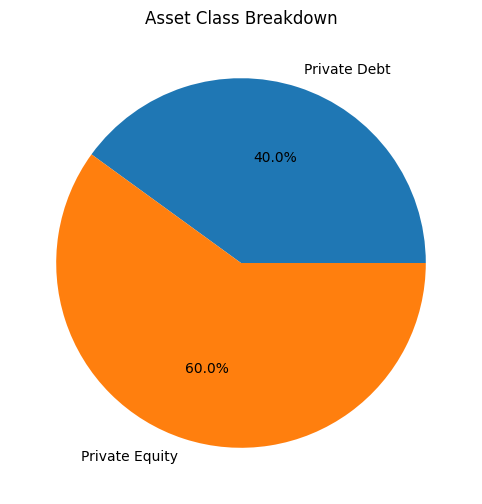

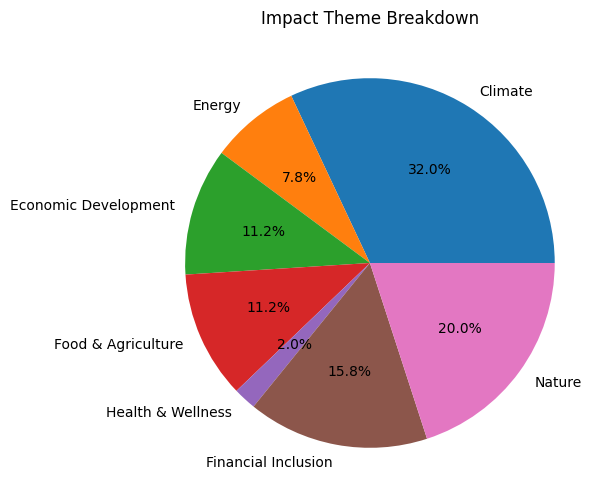

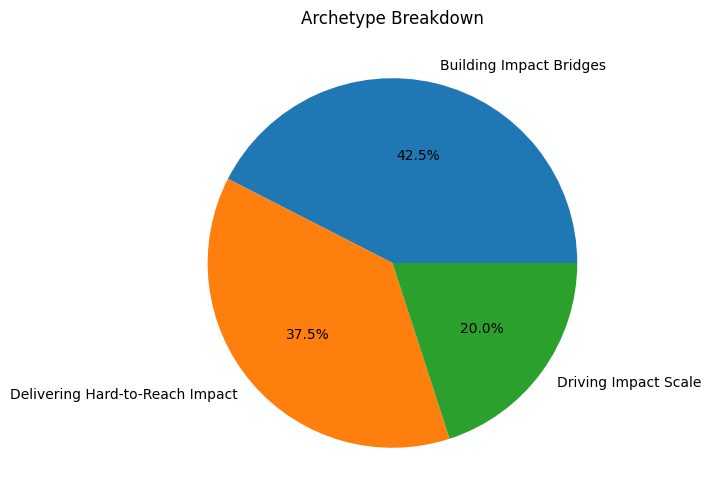

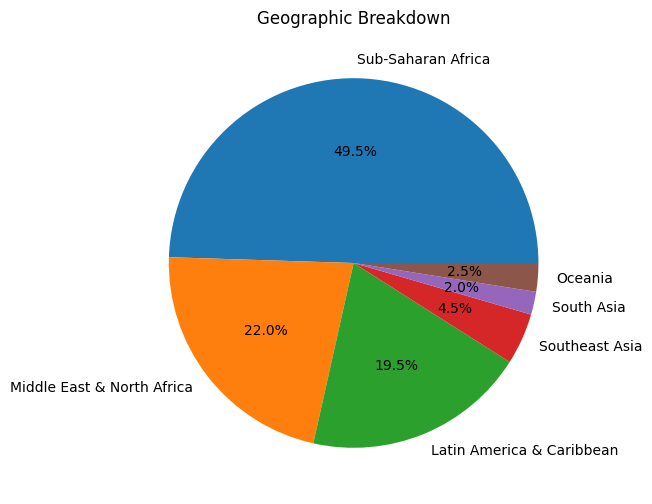

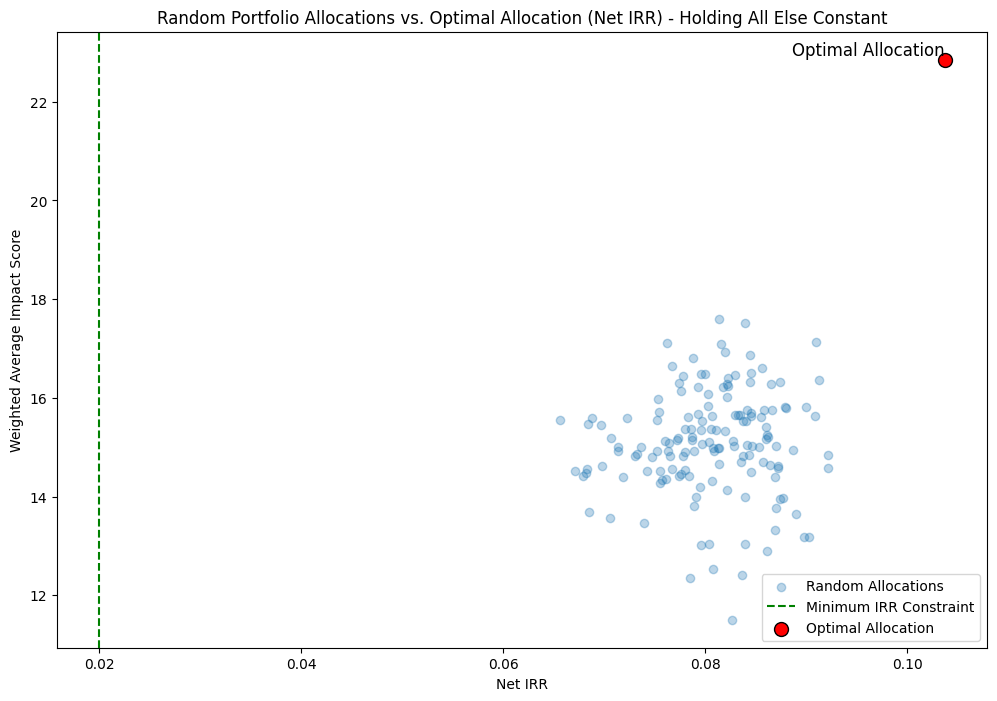

Do you want to adjust any inputs and re-run the model? (yes/no): no
Enter the name for the HTML report (without extension): optimizing on-ground additionality
Enter a description for the portfolio report: Equally weighting two on-ground additionality metrics
HTML report generated as 'optimizing on-ground additionality.html'
PDF report generated as 'optimizing on-ground additionality.pdf'


In [13]:
import numpy as np
import pandas as pd
from scipy.optimize import linprog
from scipy.stats import norm
import pdfkit
import os

# Define the categories and their corresponding metrics
categories = {
    "On-Ground Additionality": ["Degree of Underserved Beneficiary", "Depth of Improvement"],
    "Manager Additionality": [
        "Org Mission Alignment", "Resilience", "Expertise", "Expert Endorsement",
        "Market Neglected-ness", "Model Innovation", "Model Replicability", "Scalability"
    ],
    "Trimtab Additionality": ["Financial Additionality", "Strategic Additionality"],
    "Financial Profile": ["Investment Risk -- Principal Loss", "Investment Risk -- Liquidity",
                          "Concessionality - Certainty", "Concessionality - Degree"]
}

def initialize(fund_data_file):
    # Load the fund data from a CSV file
    fund_data = pd.read_csv(fund_data_file)
    fund_data.dropna(how='any', inplace=True)  # Drops any funds with missing data

    # Append risk metrics to the fund data
    fund_data = append_risk_metrics(fund_data)

    # Display categories and select metrics
    selected_categories, selected_metrics = select_categories()

    # Initialize weights and allow user to adjust
    weights_df = initialize_weights_df(selected_metrics)
    weights_df = adjust_weights(weights_df)

    # Collect constraints from the user
    constraints = collect_constraints(fund_data)
    constraints = review_constraints(constraints, fund_data)

    return fund_data, weights_df, constraints

def optimize_and_analyze(fund_data, weights_df, constraints):
    # Optimize the portfolio based on the constraints and weighted scores
    allocated_funds, total_score, fund_data = optimize_portfolio(fund_data, weights_df, constraints)

    if allocated_funds is not None:
        print("Optimal Portfolio Allocation:")

        # Call the portfolio analytics function
        analytics_output = portfolio_analytics(allocated_funds, constraints)

        # Perform portfolio analytics visuals before asking for input adjustment
        visuals_output = portfolio_analytics_visuals(allocated_funds, fund_data, constraints)

        return allocated_funds, analytics_output, visuals_output
    else:
        print("Optimization failed. Please check the constraints and input data.")
        return None, None, None

def generate_report(filename, user_description, weights_df, constraints, analytics_output, visuals_output, sensitivity_table=None):
    # Convert the constraints dictionary to a DataFrame for HTML rendering
    constraints_df = pd.DataFrame(list(constraints.items()), columns=['Constraint', 'Value'])

    html_content = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Portfolio Report</title>
    </head>
    <body>
        <h1>Portfolio Report</h1>

        <!-- User-provided description -->
        <h3 style="font-size: 18px; color: gray;">{user_description}</h3>

        <h2>Weights DataFrame</h2>
        {weights_df.to_html()}

        <h2>Constraints</h2>
        {constraints_df.to_html()}

        <h2>Portfolio Analytics</h2>
        <pre>{analytics_output}</pre>

        <h2>Portfolio Analytics Visuals</h2>
        {visuals_output}
    """

    if sensitivity_table is not None:
        html_content += f"""
        <h2>Sensitivity Table</h2>
        {sensitivity_table.to_html()}
        """

    html_content += """
    </body>
    </html>
    """

    with open(filename, 'w') as file:
        file.write(html_content)

    print(f"HTML report generated as '{filename}'")

def main():
    # Initialize the data and constraints
    fund_data, weights_df, constraints = initialize('finalized_backend_fund_data.csv')

    while True:
        # Optimize and analyze the portfolio
        allocated_funds, analytics_output, visuals_output = optimize_and_analyze(fund_data, weights_df, constraints)

        # Only ask to re-run the model if allocation was successful
        if allocated_funds is not None:
            adjust_inputs = get_yes_no_input("Do you want to adjust any inputs and re-run the model? (yes/no): ")
            if adjust_inputs == 'yes':
                # Adjust weights and constraints
                weights_df = adjust_weights(weights_df)
                constraints = review_constraints(constraints, fund_data)
                continue  # Re-run the optimization loop with adjusted inputs
            else:
                break
        else:
            break  # Exit the loop if optimization failed

    # Prompt the user for the HTML file name and description
    html_file_name = input("Enter the name for the reports (without extension): ").strip() + ".html"
    user_description = input("Enter a description for the portfolio report: ").strip()

    # Generate the HTML report
    generate_report(html_file_name, user_description, weights_df, constraints, analytics_output, visuals_output)

    # Get the base name without the file extension
    base_name = os.path.splitext(html_file_name)[0]

    # Create the PDF file name by appending .pdf to the base name
    pdf_file_name = base_name + '.pdf'

    # Generate identical pdf reprot
    pdfkit.from_file(html_file_name, pdf_file_name)
    print(f"PDF report generated as '{pdf_file_name}'")


if __name__ == "__main__":
    main()


In [14]:

#Relevant installation
# pip install pdfkit
# !apt-get install wkhtmltopdf # Install wkhtmltopdf on your Linux machine